# Dumb ML engineer's starter pack

## Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from collections import Counter

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
from random import seed

RANDOM_STATE = 42
RANDOM_SEED = 42

seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize

from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data exploration & feature extraction

### Loading data

In [ ]:
df_train = pd.read_csv('csv/df_train.csv')
X_train = df_train['message']
y_train = df_train['class']

In [ ]:
df_test = pd.read_csv('csv/df_test.csv')
X_test = df_test['message']

In [ ]:
X_test.head(20)

0                                                Моожет
1                        Ребят, спасибо за поздравление
2                                               мне нет
3                         в локальном минимуме застряла
4                      У меня 19 определений = 19 цифр?
5                                           (инфопоиск)
6     Они бы ещё написали, что время вывешивания выв...
7                                                  Окей
8                                              for free
9                 правильнее будет скинуть это вот сюда
10                                      (это не вопрос)
11       Нет\nОн просто иногда забывал\nОн записывал их
12                                      Завтра по идее?
13                                        понял, пасибо
14                                 Так что пофиг, думаю
15                                         Я выше писал
16    Наверное, круто делать изменения в расписании[...
17                                  в общем хочу

In [ ]:
df_train.head(5)

,message,class
0,"На сайте написано, что баллы больше 4 в сумме ...",1
1,7 + (87-64) по идее,6
2,"3 газеты - 25.09, 23.10, 27.11 - 2 статьи поли...",11
3,что за сайт?),6
4,"я еще писал, что выбирал самое похожее слово, ...",7


In [ ]:
X_train.shape

(2779,)

In [ ]:
df_test.head(5)

,message
0,Моожет
1,"Ребят, спасибо за поздравление"
2,мне нет
3,в локальном минимуме застряла
4,У меня 19 определений = 19 цифр?


In [ ]:
X_test.shape

(309,)

In [ ]:
y_train.value_counts()

2     428
0     381
6     279
1     270
5     268
7     216
8     210
4     145
12    138
11    136
10    118
3     106
9      84
Name: class, dtype: int64

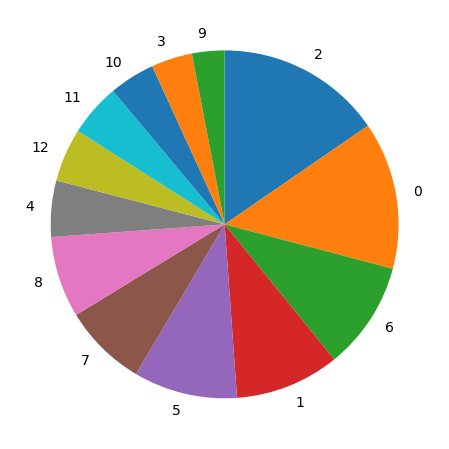

In [ ]:
cnts = y_train.value_counts()
plt.rcParams['font.size'] = 14
plt.figure(figsize=(10, 8))
plt.pie(cnts, labels=cnts.index, counterclock=False, startangle=90);

### Custom features

In [ ]:
def hasCapitalisedWords(msg):
  words = msg.split()
  if len(words) == 0:
    return 0
  return int(words[0][0].isupper())


def countSimpleSmiles(msg):
  stack = 0
  for letter in msg:
    if letter == '(':
      stack -= 1
    elif letter == ')':
      stack += 1
  return stack

PUNCTUATION = '.,'
def hasPunctuation(msg):
  c = msg.count(" - ")
  for letter in msg:
    if letter in PUNCTUATION:
      c += 1
  return c

def hasExclamations(msg):
  return msg.count('!')

def onlySigns(msg):
  return int(not any(map(lambda x: x.isalpha(), msg)))

def hasCaps(msg):
  for word in msg.split():
    if word.isupper():
      return 1
  return 0

RUSSIAN_ALPHABET = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
def onlyEnglish(msg):
  for letter in msg:
    if letter in RUSSIAN_ALPHABET:
      return 0
  only_signs = onlySigns(msg)
  return 1 if not only_signs else 0

def verbGender(msg):
  gender_c = 0
  for word in msg.split():
    parsed_arr = morph.parse(word)
    if len(parsed_arr) == 0:
      continue
    parsed = parsed_arr[0]
    if parsed.tag.POS not in ["INFN", "VERB"]:
      continue
    gender = parsed.tag.gender
    if gender == "masc":
      gender_c += 1
    elif gender == "femn":
      gender_c -= 1
  return gender_c


def hasDottedSignes(msg):
  return msg.count(":)") + msg.count(":(")


def hasTrippleDots(msg):
  return msg.count("...")


def hasObscureWords(msg):
  words = msg.split()
  c = 0
  for word in words:
    if word.isalpha() and morph.parse(word)[0].tag.POS is None:
      c += 1
  return c

def usesAtSigns(msg):
  return msg.count('@')

In [ ]:
# Несколько раз менял признаки, не помню какие помогли получить лучший результат
custom_train = pd.DataFrame.from_dict({
    'CharLength': X_train.apply(len),
    'UsesCapital': X_train.apply(hasCapitalisedWords),
    'SimpleSmilesCount': X_train.apply(countSimpleSmiles),
    'UsesPunctuation': X_train.apply(hasPunctuation),
    'LineLength': X_train.apply(lambda msg: msg.count('\n') + 1),
    'WordsCount': X_train.apply(lambda msg: len(msg.split())),
    'HasExclamations': X_train.apply(hasExclamations),
    'HasCaps': X_train.apply(hasCaps),
    'VerbGender': X_train.apply(verbGender),
    'HasDottedSignes': X_train.apply(hasDottedSignes),
    'HasTrippleDots': X_train.apply(hasTrippleDots),
    'UsesAtSigns': X_train.apply(usesAtSigns)
})

In [ ]:
custom_test = pd.DataFrame.from_dict({
    'CharLength': X_test.apply(len),
    'UsesCapital': X_test.apply(hasCapitalisedWords),
    'SimpleSmilesCount': X_test.apply(countSimpleSmiles),
    'UsesPunctuation': X_test.apply(hasPunctuation),
    'LineLength': X_test.apply(lambda msg: msg.count('\n') + 1),
    'WordsCount': X_test.apply(lambda msg: len(msg.split())),
    'HasExclamations': X_test.apply(hasExclamations),
    'HasCaps': X_test.apply(hasCaps),
    'VerbGender': X_test.apply(verbGender),
    'HasDottedSignes': X_test.apply(hasDottedSignes),
    'HasTrippleDots': X_test.apply(hasTrippleDots),
    'UsesAtSigns': X_test.apply(usesAtSigns)
})

In [ ]:
custom_train.head(10)

,CharLength,UsesCapital,SimpleSmilesCount,UsesPunctuation,LineLength,WordsCount,HasExclamations,HasCaps,VerbGender,HasDottedSignes,HasTrippleDots,UsesAtSigns
0,62,1,0,1,1,12,0,0,0,0,0,0
1,19,0,0,0,1,5,0,0,0,0,0,0
2,70,0,0,7,1,12,0,0,0,0,0,0
3,13,0,1,0,1,3,0,0,0,0,0,0
4,61,0,0,2,1,10,0,0,1,0,0,0
5,8,0,0,0,1,1,0,0,0,0,0,0
6,37,0,0,0,1,6,0,0,0,0,0,0
7,81,1,0,2,1,13,0,0,1,0,0,0
8,16,0,1,0,1,3,0,0,0,0,0,0
9,21,1,0,0,1,3,0,0,0,0,0,0


In [ ]:
pd.concat([custom_train, y_train], axis=1).corr()

,CharLength,UsesCapital,SimpleSmilesCount,UsesPunctuation,LineLength,WordsCount,HasExclamations,HasCaps,VerbGender,HasDottedSignes,HasTrippleDots,UsesAtSigns,class
CharLength,1.000000,0.034076,-0.015409,0.675939,0.423435,0.978204,0.114661,0.134139,0.111063,-0.008343,0.096125,-0.016326,-0.027216
UsesCapital,0.034076,1.000000,0.024375,0.004277,0.028403,0.033563,0.027210,0.290150,-0.007053,-0.028509,-0.008792,-0.056171,-0.043899
SimpleSmilesCount,-0.015409,0.024375,1.000000,-0.007384,-0.011661,-0.021550,-0.011668,-0.009855,0.009698,0.101619,-0.012422,0.016871,-0.039865
UsesPunctuation,0.675939,0.004277,-0.007384,1.000000,0.292477,0.660155,0.042793,0.033580,0.061098,0.006921,0.331998,-0.004228,-0.045021
LineLength,0.423435,0.028403,-0.011661,0.292477,1.000000,0.422770,0.285879,0.091047,0.015677,-0.007761,0.115084,0.018876,-0.027127
WordsCount,0.978204,0.033563,-0.021550,0.660155,0.422770,1.000000,0.097986,0.179405,0.120374,-0.008512,0.090144,-0.022990,-0.026725
HasExclamations,0.114661,0.027210,-0.011668,0.042793,0.285879,0.097986,1.000000,0.012540,-0.014815,-0.003570,0.035199,-0.005928,-0.010973
HasCaps,0.134139,0.290150,-0.009855,0.033580,0.091047,0.179405,0.012540,1.000000,-0.008859,-0.017151,0.002360,-0.013203,0.039042
VerbGender,0.111063,-0.007053,0.009698,0.061098,0.015677,0.120374,-0.014815,-0.008859,1.000000,-0.005981,0.023964,0.006256,-0.036652
HasDottedSignes,-0.008343,-0.028509,0.101619,0.006921,-0.007761,-0.008512,-0.003570,-0.017151,-0.005981,1.000000,-0.003699,-0.002393,0.043703


### Length features

In [ ]:
lens_train = pd.DataFrame.from_dict({
    'CharLength': X_train.apply(len),
    'WordLength': X_train.apply(lambda msg: len(msg.split())),
    'LineLength': X_train.apply(lambda msg: msg.count('\n') + 1),
})

In [ ]:
lens_test = pd.DataFrame.from_dict({
    'CharLength': X_test.apply(len),
    'WordLength': X_test.apply(lambda msg: len(msg.split())),
    'LineLength': X_test.apply(lambda msg: msg.count('\n') + 1),
})

In [ ]:
lens_train.head(5)

,CharLength,WordLength,LineLength
0,62,12,1
1,19,5,1
2,70,12,1
3,13,3,1
4,61,10,1


In [ ]:
pd.concat([lens_train, y_train], axis=1).corr()

,CharLength,WordLength,LineLength,class
CharLength,1.000000,0.978204,0.423435,-0.027216
WordLength,0.978204,1.000000,0.422770,-0.026725
LineLength,0.423435,0.422770,1.000000,-0.027127
class,-0.027216,-0.026725,-0.027127,1.000000


### Character features

In [ ]:
char_vect = CountVectorizer(
    lowercase=False,
    analyzer='char',
    min_df=3,
    max_df=1.0,
    ngram_range=(1, 2),
)

In [ ]:
print(X_train)

0       На сайте написано, что баллы больше 4 в сумме ...
1                                     7 + (87-64) по идее
2       3 газеты - 25.09, 23.10, 27.11 - 2 статьи поли...
3                                           что за сайт?)
4       я еще писал, что выбирал самое похожее слово, ...
                              ...                        
2774                      У них нет телефона для справки?
2775                                Ладно. Выкладывай уже
2776        А там написано, что больше 14 - две аудитории
2777                              Что это за жучки у него
2778       На консультации можно будет посмотреть я думаю
Name: message, Length: 2779, dtype: object


In [ ]:
chars_train = pd.DataFrame.sparse.from_spmatrix(
    char_vect.fit_transform(X_train)
) 
chars_test = pd.DataFrame.sparse.from_spmatrix(
    char_vect.transform(X_test)
) 

In [ ]:
chars_train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,2,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(char_vect.vocabulary_)

1343

In [ ]:
''.join(sorted(key for key in char_vect.vocabulary_.keys() if len(key) == 1))

'\n !"()*+,-./0123456789:=>?@ABCDEFGLMNOPRSTX[]^_abcdefghijklmnoprstuvwxyz«»АБВГДЕЖЗИКЛМНОПРСТУФХЧЩЫЭЯабвгдежзийклмнопрстуфхцчшщъыьэюяё—'

### POS features

In [ ]:
def pos_count(text):
    result = {
        pos: 0 for pos in morph.TagClass.PARTS_OF_SPEECH
    }
    result.update(Counter(filter(
        lambda pos: pos is not None,
        (morph.parse(token)[0].tag.POS for token in word_tokenize(text, language='russian'))
    )))
    return result

In [ ]:
pos_train = pd.DataFrame(
    pos_count(row) for row in X_train
)

In [ ]:
pos_train.head()

,ADVB,PREP,ADJF,COMP,INFN,CONJ,PRTS,VERB,PRED,PRTF,PRCL,INTJ,ADJS,NUMR,GRND,NPRO,NOUN
0,0,3,0,1,0,1,1,1,0,0,0,0,0,0,0,0,3
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3
3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,1,1,2,0,0,1,0,2,0,1,0,0,0,0,0,1,1


In [ ]:
pos_test = pd.DataFrame(
    pos_count(row) for row in X_test
)

In [ ]:
pos_test.head()

,ADVB,PREP,ADJF,COMP,INFN,CONJ,PRTS,VERB,PRED,PRTF,PRCL,INTJ,ADJS,NUMR,GRND,NPRO,NOUN
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2


### TF-IDF features

In [ ]:
print(*nltk.corpus.stopwords.words('russian'), sep=' ')

и в во не что он на я с со как а то все она так его но да ты к у же вы за бы по только ее мне было вот от меня еще нет о из ему теперь когда даже ну вдруг ли если уже или ни быть был него до вас нибудь опять уж вам ведь там потом себя ничего ей может они тут где есть надо ней для мы тебя их чем была сам чтоб без будто чего раз тоже себе под будет ж тогда кто этот того потому этого какой совсем ним здесь этом один почти мой тем чтобы нее сейчас были куда зачем всех никогда можно при наконец два об другой хоть после над больше тот через эти нас про всего них какая много разве три эту моя впрочем хорошо свою этой перед иногда лучше чуть том нельзя такой им более всегда конечно всю между


In [ ]:
def tfidf_tokenize(text):
    return list(map(lambda word: morph.parse(word)[0].normal_form,
                    word_tokenize(text, language='russian')))

In [ ]:
tfidf_vect = TfidfVectorizer(
    tokenizer=tfidf_tokenize,
    max_df=0.95,
    min_df=3,
    ngram_range=(1, 2),
    max_features=100_000,
    stop_words=nltk.corpus.stopwords.words('russian'),
)

In [ ]:
tfidf_train = pd.DataFrame.sparse.from_spmatrix(
    tfidf_vect.fit_transform(X_train)
)
tfidf_test = pd.DataFrame.sparse.from_spmatrix(
    tfidf_vect.transform(X_test)
)

In [ ]:
tfidf_train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.128159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.33933,0.0,0.0,0.0,0.0,0.242840,0.0,0.0,0.0,0.0,0.0,0.443768,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.297530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.343077,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.254535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Merging features & splitting data

In [ ]:
# dense_train = pd.concat([lens_train, pos_train], axis=1)
dense_train = pd.concat([custom_train, tfidf_train, chars_train, pos_train], axis=1)
dense_train.head(5)

,CharLength,UsesCapital,SimpleSmilesCount,UsesPunctuation,LineLength,WordsCount,HasExclamations,HasCaps,VerbGender,HasDottedSignes,HasTrippleDots,UsesAtSigns,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,ADVB,PREP,ADJF,COMP,INFN,CONJ,PRTS,VERB,PRED,PRTF,PRCL,INTJ,ADJS,NUMR,GRND,NPRO,NOUN
0,62,1,0,1,1,12,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.128159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,1,1,0,0,0,0,0,0,0,0,3
1,19,0,0,0,1,5,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.33933,0.0,0.0,0.0,0.0,0.242840,0.0,0.0,0.0,0.0,0.0,0.443768,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,70,0,0,7,1,12,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.297530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3
3,13,0,1,0,1,3,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.343077,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,61,0,0,2,1,10,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.254535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,1,0,2,0,1,0,0,0,0,0,1,1


In [ ]:
dense_test = pd.concat([custom_test, tfidf_test, chars_test, pos_test], axis=1)
dense_test.head(3)

,CharLength,UsesCapital,SimpleSmilesCount,UsesPunctuation,LineLength,WordsCount,HasExclamations,HasCaps,VerbGender,HasDottedSignes,HasTrippleDots,UsesAtSigns,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,ADVB,PREP,ADJF,COMP,INFN,CONJ,PRTS,VERB,PRED,PRTF,PRCL,INTJ,ADJS,NUMR,GRND,NPRO,NOUN
0,6,1,0,0,1,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,30,1,0,1,1,4,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
2,7,0,0,0,1,2,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
train_indices, valid_indices = train_test_split(X_train.index, test_size=0.1, random_state=RANDOM_STATE, stratify=y_train)
len(train_indices), len(valid_indices)

(2501, 278)

In [ ]:
y_train, y_valid = y_train[train_indices], y_train[valid_indices]
X_train, X_valid = X_train.loc[train_indices], X_train.loc[valid_indices]
dense_train, dense_valid = dense_train.loc[train_indices], dense_train.loc[valid_indices]

## Utils

In [ ]:
def precision_macro(y_true, y_pred):
    return precision_score(y_true, y_pred, average='macro')

def recall_macro(y_true, y_pred):
    return recall_score(y_true, y_pred, average='macro')

def f1_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')


def precision_micro(y_true, y_pred):
    return precision_score(y_true, y_pred, average='micro')

def recall_micro(y_true, y_pred):
    return recall_score(y_true, y_pred, average='micro')

def f1_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')


def get_scores(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score,

        '\nPrecision (macro)': precision_macro,
        'Recall (macro)': recall_macro,
        'F1 (macro)': f1_macro,

        '\nPrecision (micro)': precision_micro,
        'Recall (micro)': recall_micro,
        'F1 (micro)': f1_micro,
    }
    return {
        name: scorer(y_true, y_pred)
        for name, scorer in metrics.items()
    }

def score_model(model, X, y):
    y_pred = model.predict(X)
    for name, score in get_scores(y, y_pred).items():
        print(f'{name}: {score:.4f}')


f1_micro_scorer = make_scorer(f1_micro)

In [ ]:
def plot_validation_curve(
        train_scores,
        valid_scores,
        param_range,
        title='Validation curve',
        x_label='Parameter',
        y_label='Score',
        logx=False,
    ):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0.0, 1.1)
    lw = 2

    if logx:
        plt.semilogx(param_range, train_scores_mean, label="Training score", color="orange", lw=lw)
        plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score", color="green", lw=lw)
    else:
        plt.plot(param_range, train_scores_mean, label="Training score", color="orange", lw=lw)
        plt.plot(param_range, valid_scores_mean, label="Cross-validation score", color="green", lw=lw)

    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="orange",
        lw=lw,
    )
    plt.fill_between(
        param_range,
        valid_scores_mean - valid_scores_std,
        valid_scores_mean + valid_scores_std,
        alpha=0.2,
        color="green",
        lw=lw,
    )

    plt.legend(loc="best")
    plt.show()

In [ ]:
def make_submission(model, X):
    y = pd.Series(model.predict(X), name='class')
    y.to_csv('csv/submission.csv', index_label='index')

## Experiments: MLP

### MLP: dense features

In [ ]:
dense_mlp = MLPClassifier(
      random_state=RANDOM_STATE,
      batch_size=950,
      hidden_layer_sizes=(1015, 1015, 1015),
      learning_rate='adaptive',
      activation='tanh',
      solver='adam',
      learning_rate_init=3e-4,
      alpha=0.5,
      max_iter=29,
  ).fit(dense_train, y_train)
    

In [ ]:
score_model(dense_mlp, dense_train, y_train)

Accuracy: 0.8121

Precision (macro): 0.8398
Recall (macro): 0.7685
F1 (macro): 0.7924

Precision (micro): 0.8121
Recall (micro): 0.8121
F1 (micro): 0.8121


In [ ]:
score_model(dense_mlp, dense_valid, y_valid)

Accuracy: 0.3705

Precision (macro): 0.3240
Recall (macro): 0.3118
F1 (macro): 0.3089

Precision (micro): 0.3705
Recall (micro): 0.3705
F1 (micro): 0.3705


### Make submission

In [ ]:
make_submission(dense_mlp, dense_test)